In [3]:
import pandas as pd
import psycopg2
import warnings
warnings.filterwarnings('ignore')

Загрузка таблиц с сервера

In [1]:
con = "Here was the address"

In [40]:
user_data = pd.read_sql("SELECT * FROM public.user_data", con)

In [41]:
post_text_df = pd.read_sql("SELECT * FROM public.post_text_df", con)

In [5]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [42]:
# Выгружаем таблицу с балансом классов, где будет взято максимум по 13 записей каждого класса на пользователя

feed_data = pd.read_sql(
    """
    WITH tab1 AS (SELECT timestamp, user_id, post_id, action, target, ROW_NUMBER() OVER (PARTITION BY user_id, target) rn
    FROM public.feed_data
    WHERE action = 'view')
    SELECT timestamp, user_id, post_id, action, target
    FROM tab1
    WHERE rn < 14
    """,
    con=con)

Обработка данных

In [43]:
# Удаляем колонку action, т.к. она дублирует таргет

feed_data = feed_data.drop(['action'], axis=1)

In [44]:
# Преобразования текста

import re
post_text_df['post'] = post_text_df['text'].apply(lambda x: x.lower())
post_text_df['post'] = post_text_df['post'].apply(lambda x: re.sub('[^A-Za-z]', ' ', x))
post_text_df['post'] = post_text_df['post'].apply(lambda x: x.replace('  ', ' ')[:-1])

In [45]:
# Векторизация текста

import numpy as np
vec = {}
with open('glove.6B.100d.txt', "r", encoding='utf-8') as file:
    for line in file:
        values = line.split()
        vec[values[0]] = np.asarray(values[1:], dtype='float32')

mean_vec = []
post_id_list = []
topic_list = []

for p in range(0, post_text_df.shape[0]):
    new_list = np.array([0.0] * 100)
    test = [i for i in post_text_df['post'][p].split(" ") if i != ""]
    for k in test:
        try:
            new_list += vec[k]
        except KeyError:
            continue
    mean_vec.append(new_list / len(test))
    post_id_list.append(post_text_df['post_id'][p])
    topic_list.append(post_text_df['topic'][p])

In [46]:
vec_df = pd.DataFrame(mean_vec)
vec_df['topic'] = topic_list
vec_df['post_id'] = post_id_list

In [47]:
# Делаем единую таблицу, склеивая все таблицы вместе

df = feed_data.join(vec_df.set_index('post_id'), on='post_id')
df = df.join(user_data.set_index('user_id'), on='user_id')

In [48]:
df

,timestamp,user_id,post_id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,topic,gender,age,country,city,exp_group,os,source
0,2021-10-07 20:51:32,200,2152,0,-0.110600,0.158036,0.317331,-0.267268,0.116291,0.241669,-0.100978,-0.004086,-0.012754,-0.004677,0.041392,-0.039090,0.200914,0.000529,0.106836,-0.105822,0.265627,-0.010058,-0.235348,0.032956,0.127701,-0.087101,0.272863,0.140286,0.178450,-0.102595,0.027241,-0.193569,-0.094180,-0.090900,0.030049,0.498155,-0.015551,0.050512,0.120193,0.137410,0.034827,0.043884,-0.030520,-0.072249,-0.402495,-0.195835,0.037266,-0.275887,0.036240,0.112092,0.118041,-0.316103,-0.031482,-0.523562,0.141086,0.116764,0.121193,0.782769,-0.321608,-1.998755,-0.081679,-0.175854,1.492782,0.384952,-0.098559,0.654324,-0.112594,0.007225,0.534991,0.094866,0.273305,0.207404,0.313191,-0.157862,-0.046737,-0.214257,-0.121641,-0.355317,0.208997,0.123804,-0.113762,0.007982,-0.838860,-0.027794,0.597046,-0.074507,-0.477216,0.088714,-1.273125,-0.138738,0.123333,-0.148138,-0.132245,-0.179667,-0.056966,0.072426,0.037868,0.102969,-0.351994,-0.014416,-0.186383,-0.338552,0.485533,0.107606,tech,1,34,Russia,Degtyarsk,3,Android,ads
1,2021-11-26 15:38:17,200,2892,0,0.024968,0.047243,0.163222,-0.150592,-0.014116,0.273435,-0.307755,0.109140,-0.134409,-0.078155,0.013250,0.017291,0.172344,0.015207,0.076641,-0.105166,0.300465,-0.009192,-0.279357,-0.013752,0.137003,-0.005253,0.143204,-0.031940,0.324931,0.124368,-0.063804,-0.362397,0.061958,-0.242507,0.171781,0.388325,0.212181,0.079655,-0.033540,0.114038,0.013193,0.156654,0.147625,0.022676,-0.203100,-0.140001,0.179139,-0.392726,-0.126542,-0.002076,0.004897,-0.074976,-0.194985,-0.591673,0.135311,0.102178,-0.055169,0.711826,-0.233106,-1.481913,0.034132,-0.093084,1.325375,0.222843,-0.040972,0.466233,-0.188321,-0.065139,0.535808,0.073976,0.463523,0.174873,-0.062824,-0.258822,0.118632,-0.093219,0.000965,-0.282359,0.101856,0.025279,-0.096824,-0.014934,-0.617931,0.074864,0.444687,-0.047502,-0.227155,0.147056,-0.979455,-0.103487,-0.061431,-0.038226,0.061666,-0.216175,-0.073600,-0.126227,-0.076780,0.139903,-0.135889,-0.075404,-0.064163,-0.072698,0.438390,0.154079,covid,1,34,Russia,Degtyarsk,3,Android,ads
2,2021-11-26 15:37:15,200,1222,0,-0.117387,-0.007289,0.264686,-0.305956,0.029469,0.140460,-0.255315,0.201598,-0.134811,0.084073,-0.036857,-0.014932,0.267751,0.018741,0.056394,-0.326402,0.211653,0.014955,-0.509953,0.122014,0.289868,-0.121681,0.270592,-0.107065,0.008103,-0.237036,-0.029258,-0.415936,0.010268,-0.055715,0.037990,0.371077,-0.090732,0.074785,-0.001411,0.179133,0.050236,0.233286,-0.057473,-0.089961,-0.528697,-0.222986,0.267016,-0.253819,-0.033366,-0.002180,0.186400,-0.348701,-0.101577,-0.568515,0.104158,-0.161983,0.085856,1.045683,-0.233091,-2.108679,0.008121,-0.192725,1.466379,0.506079,-0.109799,0.447082,-0.187244,0.129801,0.734695,-0.050614,0.274687,0.422111,0.231428,-0.107825,0.051523,-0.338580,-0.189691,-0.452525,0.158440,-0.033870,-0.157860,0.087681,-0.926900,-0.028776,0.611615,0.011332,-0.291784,0.077055,-1.245602,-0.242472,0.083978,-0.001779,-0.093921,-0.340239,0.075887,-0.243810,-0.196551,0.155610,-0.475351,0.028354,-0.158662,-0.202085,0.465959,0.136424,politics,1,34,Russia,Degtyarsk,3,Android,ads
3,2021-11-26 15:34:29,200,1029,0,-0.076897,0.060685,0.381380,-0.142995,0.046643,-0.023629,-0.255729,0.193547,-0.083760,0.015148,-0.036826,-0.014223,0.309358,0.060096,0.029404,-0.151744,0.181538,-0.053689,-0.473710,-0.022648,0.306752,-0.030136,0.283097,0.054579,0.148822,-0.110742,-0.071676,-0.404986,0.037608,-0.062261,-0.077913,0.381783,-0.072503,0.059230,-0.034065,0.310213,0.185519,0.215138,-0.201499,-0.110466,-0.620706,-0.300311,0.258116,-0.240101,0.023290,-0.084967,0.209924,-0.325491,-0.151877,-0.743352,0.124875,-0.036601,0.127661,1.0691

In [49]:
# Применяем OHE

for col in ['topic', 'country', 'exp_group', 'os', 'source']:
    one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

In [50]:
# Применяем Label Encoder

from sklearn.preprocessing import LabelEncoder

df['city'] = LabelEncoder().fit_transform(df['city'])

In [51]:
# Сортируем данные по времени

df = df.sort_values('timestamp')

In [52]:
# Берём из колонки со временем час и месяц просмотра поста

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

In [53]:
# Удаляем колонку со временем

df = df.drop(['timestamp'], axis=1)

In [54]:
# Делаем колонки user_id и post_id индексами

df = df.set_index(['user_id', 'post_id'])

In [55]:
# Смотрим итоговый датафрейм и получаем удовольствие от проделанной работы

df

,,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,gender,age,city,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,country_Turkey,country_Ukraine,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic,hour,month
user_id,post_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
115794,6330,0,-0.058004,0.137158,0.465046,-0.285209,-0.093211,0.175104,-0.197933,0.222862,-0.112845,-0.060936,0.065657,0.027624,0.212548,-0.022810,0.177425,-0.236421,0.127714,0.084649,-0.306837,0.286201,0.195504,-0.075870,0.177271,-0.134675,0.298899,-0.102663,-0.016643,-0.390054,0.121341,-0.126916,-0.101997,0.474497,0.060470,0.126301,-0.033891,0.299553,0.020234,0.255834,-0.057312,-0.179659,-0.387406,-0.164472,0.007996,-0.234427,-0.124018,-0.006071,0.187438,-0.334650,-0.063029,-0.755127,-0.032627,-0.072725,0.192014,1.011372,-0.252252,-2.420036,-0.032113,-0.171139,1.417533,0.462810,-0.086012,0.873721,-0.232480,0.082245,0.794084,-0.008482,0.484701,0.269147,0.100070,-0.129114,0.121751,-0.282276,-0.079110,-0.318757,0.206723,0.143874,-0.103933,-0.023377,-0.771764,-0.041186,0.451366,0.037792,-0.402556,0.103765,-1.443515,-0.255641,-0.059354,-0.089791,-0.168747,-0.361211,-0.020977,-0.094389,-0.083058,0.146707,-0.487348,-0.125824,-0.315062,-0.305574,0.513341,0.348719,1,28,562,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,6,10
52958,3082,1,-0.114198,0.051180,0.183766,-0.117902,0.201700,-0.072287,-0.295228,0.230055,-0.105225,-0.051663,0.087264,0.052760,0.105422,0.074699,0.183761,-0.327326,0.049103,0.033761,-0.100306,0.067336,0.231302,-0.002239,0.138375,0.206872,0.141681,-0.049612,-0.069414,-0.152245,0.133939,-0.254867,-0.065352,0.201084,-0.166168,-0.067011,0.020626,0.488156,0.331703,0.080872,-0.079748,-0.071220,-0.215643,-0.230064,-0.150604,-0.159131,0.159653,0.048501,-0.018462,-0.234667,0.261461,-0.389836,0.136660,0.121872,0.065461,0.595912,-0.035026,-1.316301,-0.012134,-0.072903,1.414132,0.113887,-0.217876,0.297203,-0.108374,-0.188109,0.110896,0.143117,0.249632,0.127375,0.279240,-0.215552,-0.115804,-0.389136,-0.270030,-0.357806,0.082585,0.012949,0.166317,0.037966,-0.596971,-0.048841,0.418124,-0.167503,-0.245482,0.199420,-0.764731,-0.104729,0.205859,0.089975,-0.282842,-0.119614,-0.155306,0.248895,-0.022320,-0.329700,-0.318927,-0.000348,0.001033,0.120291,0.406401,0.106939,0,25,3552,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,6,10
73455,2671,1,-0.209029,0.181782,0.048764,-0.164147,0.018076,0.075424,-0.215343,0.142645,-0.093260,-0.115203,0.040569,-0.047223,0.060123,0.080155,-0.042715,0.151926,0.088436,-0.103021,-0.286950,-0.094621,0.103914,0.101787,0.161857,-0.099487,0.110726,0.187483,0.151798,-0.268905,0.237246,-0.141411,0.013227,0.255556,0.056195,0.231668,-0.051300,0.125996,0.117838,0.092174,0.141322,-0.021832,-0.334236,-0.052480,0.000913,-0.273795,-0.058819,-0.149520,-0.097484,-0.198343,-0.299207,-0.369875,0.075254,-0.021661,-0.038530,0.495920,-0.217890,-1.298784,0.089278,0.170886,0.750231,0.039929,-0.113354,0.235921,-0.084512,-0.204618,0.389555,0.104898,0.277889,0.333546,0.112222,0.074867,0.191096,-0.061372,-0.233018,-0.244707,0.026647,0.000263,-0.142402,0.149314,-0.485810,-0.114401,0.317777,-0.239758,-0.082860,-0.026492,-0.794632,-0.046807,-0.014130,0.075311,-0.034771,-0.333378,0.039742,-0.038612,0.037777,0.232870,-0.086081,0.012386,-0.022331,-0.152662,0.283647,0.266477,1,17,2111,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,6,10
632,1196,0,0.006673,0.010590,0.269132,-0.217974,0.104169,0.199360,-0.231639,0.189219,-0.183269,0.070153,-0.047503,0.088396,0.105660,0.084944,0

Обучение модели

In [56]:
# Делим датафрейм на трейн и тест 1 к 5

train = df.iloc[:int(df.shape[0] * 4/5)]
test = df.iloc[int(df.shape[0] * 4/5):]

In [57]:
X_train = train.drop('target', axis=1)
X_test = test.drop('target', axis=1)

y_train = train['target']
y_test = test['target']

In [58]:
# Проверяем распределение классов, т.к. могло не быть достаточного количества записей на пользователя

round((y_train == 0).sum() / (y_train == 1).sum(), 2)

1.05

In [95]:
from catboost import CatBoostClassifier

# В качестве максимизируемой метрики выбрана Accuracy, т.к. Hitrate среди доступных метрик отстутсвует,
# а данная метрика поддерживает вычисление на GPU, в отличие от ROC-AUC
# К тому же в ходе экспериментов с разными метриками не было выявлено разницы в получаемом качестве на метрике Hitrate

catboost = CatBoostClassifier(iterations=900, verbose=100, eval_metric='Accuracy', depth=10, learning_rate=0.06, use_best_model=True, task_type="GPU", early_stopping_rounds=100)

catboost.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6088351	test: 0.5967528	best: 0.5967528 (0)	total: 813ms	remaining: 12m 11s
100:	learn: 0.6315239	test: 0.6367370	best: 0.6367370 (100)	total: 1m 16s	remaining: 10m 2s
200:	learn: 0.6437299	test: 0.6614216	best: 0.6614216 (200)	total: 2m 33s	remaining: 8m 55s
300:	learn: 0.6505867	test: 0.6752066	best: 0.6752649 (299)	total: 3m 50s	remaining: 7m 38s
400:	learn: 0.6553478	test: 0.6848400	best: 0.6848400 (400)	total: 5m 6s	remaining: 6m 21s
500:	learn: 0.6586382	test: 0.6901113	best: 0.6901601 (499)	total: 6m 22s	remaining: 5m 4s
600:	learn: 0.6611248	test: 0.6936215	best: 0.6936215 (600)	total: 7m 38s	remaining: 3m 48s
700:	learn: 0.6631717	test: 0.6960061	best: 0.6960061 (700)	total: 8m 54s	remaining: 2m 31s
800:	learn: 0.6651193	test: 0.6967010	best: 0.6968045 (757)	total: 10m 8s	remaining: 1m 15s
899:	learn: 0.6670746	test: 0.6969925	best: 0.6970592 (883)	total: 11m 20s	remaining: 0us
bestTest = 0.697059156
bestIteration = 883
Shrink model to first 884 iterations.


In [97]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, catboost.predict(X_test)).ravel()
all = tn + fp + fn + tp
{'True positive': round(tp/all*100, 2),
'False positive': round(fp/all*100, 2),
'True negative': round(tn/all*100, 2),
'False negative': round(fn/all*100, 2)}

{'True positive': 41.48,
 'False positive': 19.75,
 'True negative': 28.22,
 'False negative': 10.54}

0.7270745427066444

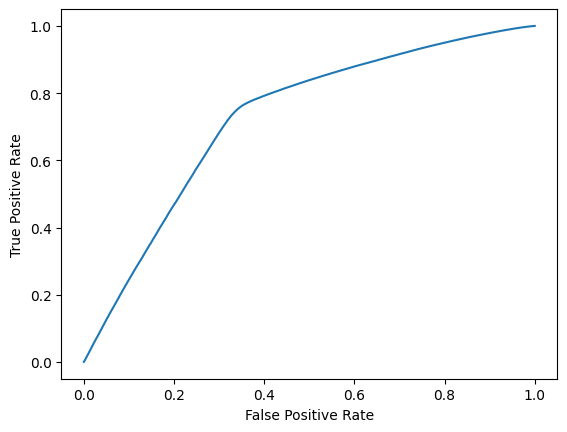

In [76]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])
fpr, tpr, threshold = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
auc(fpr, tpr)

0.7131585924330307

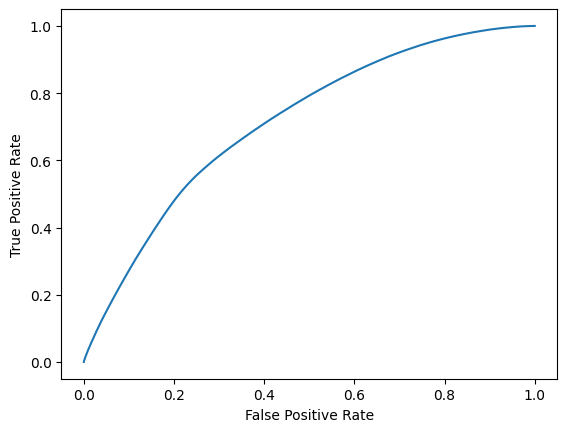

In [63]:
roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])
fpr, tpr, threshold = roc_curve(y_train, catboost.predict_proba(X_train)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
auc(fpr, tpr)

In [96]:
# Сохраняем модель

catboost.save_model('catboost_model', format="cbm")

Посмотрим ради интереса на feature importance

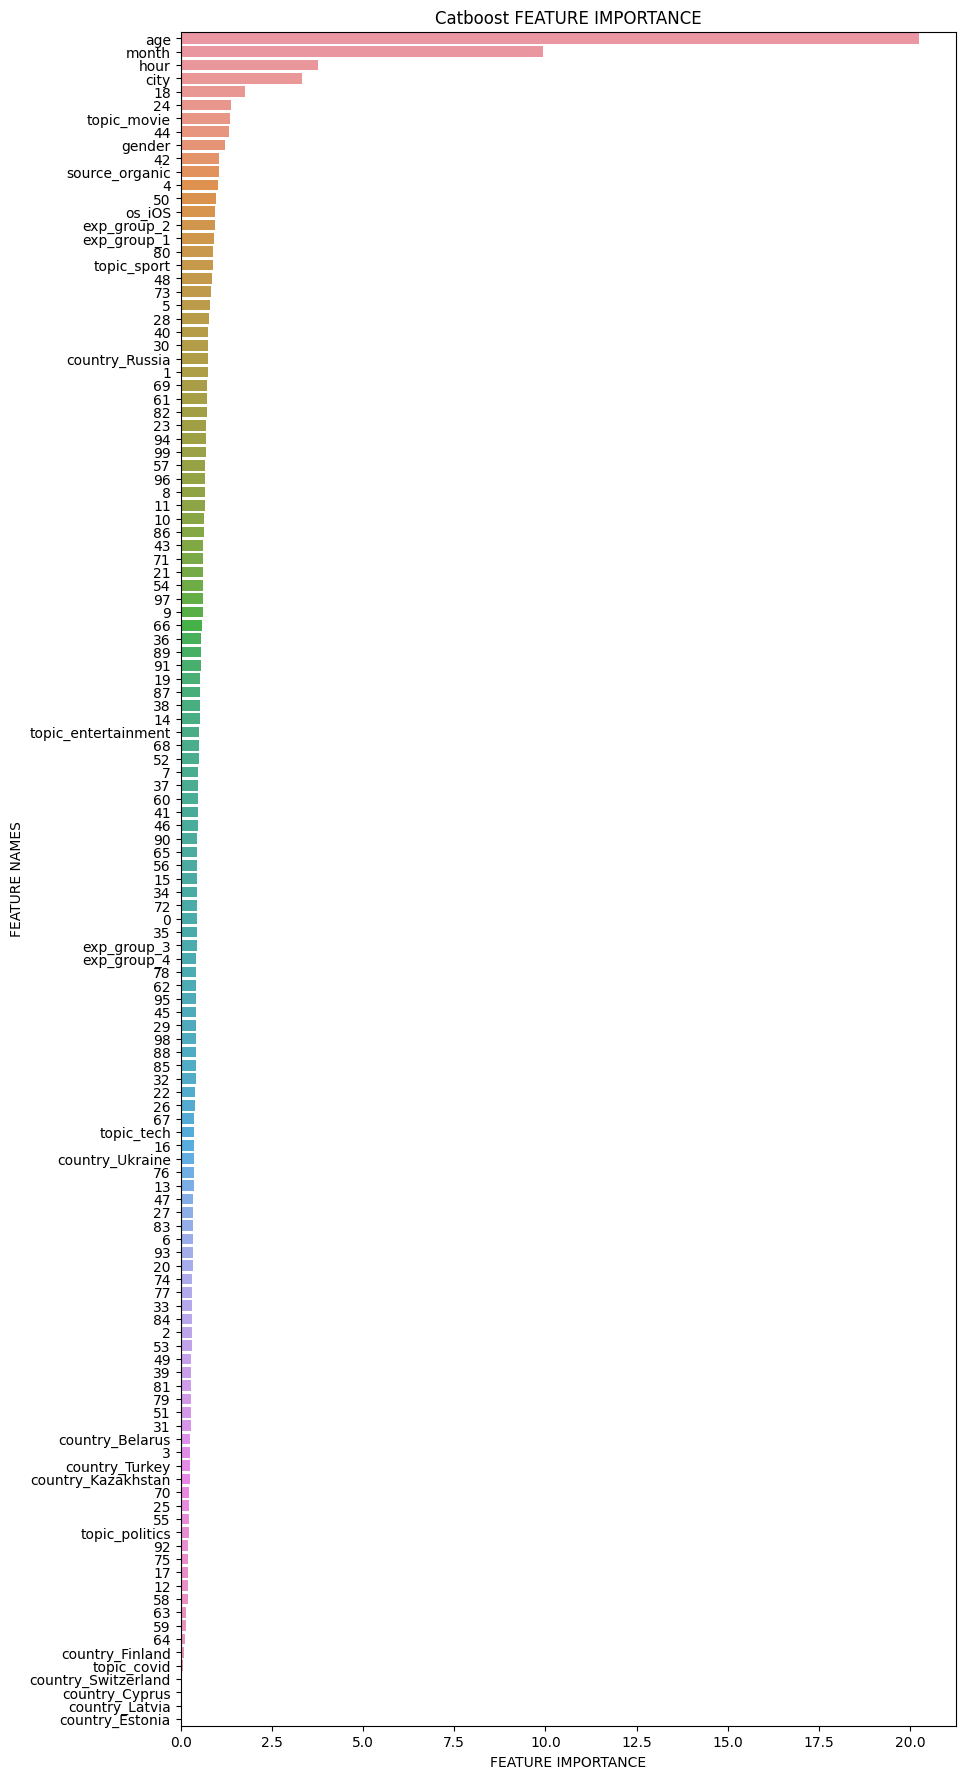

In [98]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,22))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_, X_train.columns, 'Catboost ')

Создание таблиц для загрузки в БД

In [99]:
# Выгружаем уникальных пользователей из таблицы feed_data

import pandas as pd
feed_data_all_users = pd.read_sql(
    """
    SELECT DISTINCT ON (user_id) user_id
    FROM "feed_data"
    """,
    con=con)

In [ ]:
# Формируем таблицу с данными по каждому пользователю для загрузки в БД

n_besedin_14_features_lesson_22 = feed_data_all_users.join(user_data.set_index('user_id'), on='user_id')

In [ ]:
# Применяем OHE

for col in ['country', 'exp_group', 'os', 'source']:
    one_hot = pd.get_dummies(n_besedin_14_features_lesson_22[col], prefix=col, drop_first=True)
    n_besedin_14_features_lesson_22 = pd.concat((n_besedin_14_features_lesson_22.drop(col, axis=1), one_hot), axis=1)

In [ ]:
# Применяем Label Encoder

from sklearn.preprocessing import LabelEncoder

n_besedin_14_features_lesson_22['city'] = LabelEncoder().fit_transform(n_besedin_14_features_lesson_22['city'])

In [ ]:
# Загружаем таблицу в БД

from sqlalchemy import create_engine

engine = create_engine(con)

n_besedin_14_features_lesson_22.to_sql('n_besedin_14_features_lesson_22', con=engine, if_exists='replace') # записываем таблицу

In [4]:
pd.read_sql('SELECT * FROM n_besedin_14_features_lesson_22', con=con) # считываем таблицу

,user_id,gender,age,city,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,country_Turkey,country_Ukraine,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic
0,200,1,34,651,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,201,0,37,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,202,1,17,2931,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,203,0,18,1953,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,204,0,36,125,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,1124,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163201,168549,0,18,3287,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
163202,168550,1,41,3698,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163203,168551,0,38,1953,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1


In [ ]:
# Применяем OHE для таблицы с векторами для загрузки в БД

for col in ['topic']:
    one_hot = pd.get_dummies(vec_df[col], prefix=col, drop_first=True)
    vec_df = pd.concat((vec_df.drop(col, axis=1), one_hot), axis=1)

In [ ]:
# Загружаем таблицу с векторами в БД

from sqlalchemy import create_engine

engine = create_engine(con)

vec_df.to_sql('n_besedin_14_lesson_10_vecs', con=engine, if_exists='replace') # записываем таблицу с векторами в базу